In [10]:
import os
import matplotlib.pyplot as plt

import gensim
from gensim import models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import nltk
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, BatchNormalization


from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(2018)

In [11]:
notebook_dir = os.getcwd()
rel_path = '../../data/complete_data/speeches_cleaned_spy_tnx.csv'

df=pd.read_csv(os.path.join(notebook_dir, rel_path), parse_dates=['date'])

In [12]:
df['contents'] = df['contents'].apply(lambda x: x.replace('\n\n[SECTION]\n\n', '').replace('\n', ' ').replace('\r', ' ').strip())
df

# Preprocessing

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phzeller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
stemmer = SnowballStemmer('english')

In [15]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [16]:
processed_docs = df['contents'].map(preprocess)

In [17]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abil
1 absenc
2 absorb
3 abus
4 accept
5 access
6 accomplish
7 accord
8 accur
9 achiev
10 act


In [18]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [19]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [20]:
# bow_doc_43 = bow_corpus[43]

# for i in range(len(bow_doc_43)):
#     print("Word {} (\"{}\") appears {} time.".format(bow_doc_43[i][0], 
#                                                      dictionary[bow_doc_43[i][0]], 
#                                                      bow_doc_43[i][1]))

In [21]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# LDA using bag of words

In [22]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [23]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"crisi" + 0.007*"regulatori" + 0.005*"liquid" + 0.005*"save" + 0.005*"mortgag" + 0.004*"rule" + 0.004*"communiti" + 0.004*"compani" + 0.004*"insur" + 0.004*"lend"
Topic: 1 
Words: 0.009*"liquid" + 0.007*"loan" + 0.007*"system" + 0.005*"crisi" + 0.005*"trade" + 0.005*"communiti" + 0.005*"household" + 0.005*"loss" + 0.004*"deriv" + 0.004*"model"
Topic: 2 
Words: 0.008*"liquid" + 0.008*"inflat" + 0.005*"crisi" + 0.005*"trade" + 0.004*"investor" + 0.004*"loan" + 0.004*"labor" + 0.004*"system" + 0.004*"lend" + 0.004*"recoveri"
Topic: 3 
Words: 0.010*"system" + 0.008*"technolog" + 0.008*"insur" + 0.006*"mortgag" + 0.006*"regulatori" + 0.006*"compani" + 0.005*"innov" + 0.005*"supervis" + 0.004*"loan" + 0.004*"inflat"
Topic: 4 
Words: 0.008*"technolog" + 0.007*"stress" + 0.007*"test" + 0.006*"communiti" + 0.006*"model" + 0.006*"inflat" + 0.006*"innov" + 0.006*"worker" + 0.005*"labor" + 0.004*"educ"
Topic: 5 
Words: 0.016*"inflat" + 0.013*"basel" + 0.008*"labor" + 0.007*"

# LDA using TF-IDF

In [24]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [25]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"communiti" + 0.003*"anpr" + 0.003*"inflat" + 0.002*"contact" + 0.002*"updat" + 0.002*"news" + 0.002*"novemb" + 0.002*"euro" + 0.002*"loan" + 0.002*"famili"
Topic: 1 Word: 0.004*"inflat" + 0.004*"basel" + 0.002*"communiti" + 0.002*"crisi" + 0.002*"test" + 0.002*"stress" + 0.002*"trade" + 0.002*"fomc" + 0.002*"labor" + 0.002*"fiscal"
Topic: 2 Word: 0.003*"communiti" + 0.003*"mortgag" + 0.003*"inflat" + 0.003*"liquid" + 0.003*"technolog" + 0.003*"educ" + 0.002*"worker" + 0.002*"loan" + 0.002*"hous" + 0.002*"crisi"
Topic: 3 Word: 0.005*"communiti" + 0.003*"neighborhood" + 0.003*"organ" + 0.003*"consolid" + 0.003*"regulatori" + 0.002*"affili" + 0.002*"loan" + 0.002*"insur" + 0.002*"supervisor" + 0.002*"system"
Topic: 4 Word: 0.006*"inflat" + 0.006*"basel" + 0.004*"communiti" + 0.003*"libor" + 0.002*"fomc" + 0.002*"loan" + 0.002*"currenc" + 0.002*"fiscal" + 0.002*"neutral" + 0.002*"labor"
Topic: 5 Word: 0.005*"inflat" + 0.003*"digit" + 0.003*"stablecoin" + 0.002*"labor"

# Doc2vec

In [26]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(df.contents))

In [27]:
#session crashed when i ran this, even when I had a GPU connected it didnt seem to use the GPU
from gensim.models.doc2vec import Doc2Vec
model = Doc2Vec(train_corpus, vector_size=200, window=3, min_count=1, workers=4)

In [28]:
def getVecs(model_name, corpus, size):
    vecs = [np.array(model_name[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)
train_vecs_dm = getVecs(model, train_corpus, 200)

# Predictions on SPY changes


In [29]:
def pct_change_from_day_0(announcement):
    pct_change= (announcement['SPY: d+7']/announcement['SPY: d-1'])-1
    if pct_change>0:
        return 'up'
    else:
        return 'down'

In [30]:
pct_change_from_day_0(df.iloc[141])

'up'

In [31]:
df['+7change']=df.apply(pct_change_from_day_0,axis=1)

In [32]:
df['+7change'].value_counts()

up      905
down    664
Name: +7change, dtype: int64

In [33]:
labels=df['+7change'].to_numpy()
labels_onehot=pd.get_dummies(labels).values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train_vecs_dm,labels_onehot,train_size=0.9)
print (len(X_train),len(X_test),len(y_train),len(y_test))

1412 157 1412 157


In [35]:
X_train_m, X_val, y_train_m, y_val = train_test_split(X_train,y_train,train_size=0.9)
print (len(X_train_m),len(X_val),len(y_train_m),len(y_val))

1270 142 1270 142


In [36]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(LSTM(units = 50))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

history=model.fit(X_train_m, y_train_m,validation_data=(X_val,y_val), epochs = 30, batch_size = 100)

Metal device set to: 

2022-03-14 18:55:04.638948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-14 18:55:04.639071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/30


2022-03-14 18:55:05.911878: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-14 18:55:07.587567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:07.920828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:09.912033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:11.803229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:13.334613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 0.2888 - accuracy: 0.5150

2022-03-14 18:55:17.364473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:17.463255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-14 18:55:17.717164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 13s 359ms/step - loss: 0.2888 - accuracy: 0.5150 - val_loss: 0.2479 - val_accuracy: 0.5775
Epoch 2/30
13/13 [==============================] - 1s 104ms/step - loss: 0.2739 - accuracy: 0.5315 - val_loss: 0.2463 - val_accuracy: 0.5775
Epoch 3/30
13/13 [==============================] - 1s 103ms/step - loss: 0.2668 - accuracy: 0.5480 - val_loss: 0.2452 - val_accuracy: 0.5775
Epoch 4/30
13/13 [==============================] - 1s 103ms/step - loss: 0.2628 - accuracy: 0.5512 - val_loss: 0.2446 - val_accuracy: 0.5775
Epoch 5/30
13/13 [==============================] - 1s 101ms/step - loss: 0.2590 - accuracy: 0.5646 - val_loss: 0.2441 - val_accuracy: 0.5775
Epoch 6/30
13/13 [==============================] - 1s 100ms/step - loss: 0.2656 - accuracy: 0.5394 - val_loss: 0.2440 - val_accuracy: 0.5775
Epoch 7/30
13/13 [==============================] - 1s 100ms/step - loss: 0.2550 - accuracy: 0.5535 - val_loss: 0.2440 - val_accuracy: 0.5775
Epoch 8/30
13/13

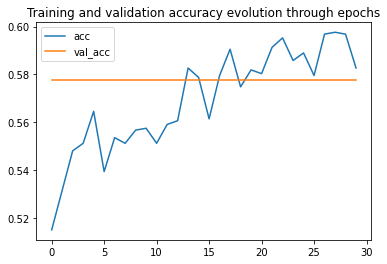

In [37]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training and validation accuracy evolution through epochs')
plt.legend()
plt.show()

In [38]:
model.evaluate(X_train,y_train)

45/45 [==============================] - 4s 68ms/step - loss: 0.2427 - accuracy: 0.5800


[0.24272184073925018, 0.5800282955169678]

In [39]:
model.evaluate(X_test,y_test)

5/5 [==============================] - 1s 161ms/step - loss: 0.2413 - accuracy: 0.5669


[0.24133917689323425, 0.5668789744377136]